In [1]:
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

## Get Data

In [2]:
# define data transformations for data augmentation and normalization
data_transforms = {
    # data augmentation
    'train': transforms.Compose([
        transforms.Resize((64,64)), # cannot load data, if size is too large
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # resnet needs input as tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255]) # normalize images
    ]),
    'val': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(), # resnet needs input as tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize images
    ]),
}

load train and validation dataset  -> only model with seperate valid dataset

In [3]:
data_dir = '../../02_data_crop_abc/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [4]:
# load data in batches for less memory storage
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

# get datasets sizes
class_names = image_datasets['train'].classes
print(class_names)

{'train': 18178, 'val': 1284}
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Model

In [5]:
# pretrained resnet model
model = models.resnet18(pretrained = True)

# freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name: # fc = fully connected
        param.requires_grad=True
    else:
        param.requires_grad=False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
import time
num_epoch = 20
history = []
print("[INFO] training the network...")
startTime = time.time()

for epoch in range(num_epoch):
    epoch_data = {'train_acc': 0.0, 'val_acc': 0.0}
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval() # for test dataset, put model on evaluation mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device) # images
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) #put image into model
                _,preds = torch.max(outputs, 1) # get prediction
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            epoch_data['train_acc'] = epoch_acc.item()
        else:
            epoch_data['val_acc'] = epoch_acc.item()

    history.append(epoch_data)
    print(f'EPOCH[{epoch}]: {epoch_data}')
endTime = time.time()
print("Training complete!")
print("[INFO] total time: {:.2f}min".format((endTime - startTime)/60))

[INFO] training the network...
EPOCH[0]: {'train_acc': 0.6193200572120146, 'val_acc': 0.5311526479750779}
EPOCH[1]: {'train_acc': 0.6161293871713059, 'val_acc': 0.530373831775701}
EPOCH[2]: {'train_acc': 0.6132687864451535, 'val_acc': 0.5334890965732088}
EPOCH[3]: {'train_acc': 0.6197601496314226, 'val_acc': 0.5389408099688473}
EPOCH[4]: {'train_acc': 0.6191000110023105, 'val_acc': 0.5514018691588785}
EPOCH[5]: {'train_acc': 0.6173946528771042, 'val_acc': 0.5116822429906542}
EPOCH[6]: {'train_acc': 0.6198151611838486, 'val_acc': 0.5225856697819314}
EPOCH[7]: {'train_acc': 0.6202552536032567, 'val_acc': 0.5311526479750779}
EPOCH[8]: {'train_acc': 0.6243811200352074, 'val_acc': 0.5490654205607477}
EPOCH[9]: {'train_acc': 0.6167895258004181, 'val_acc': 0.5093457943925234}
EPOCH[10]: {'train_acc': 0.6176146990868082, 'val_acc': 0.5163551401869159}
EPOCH[11]: {'train_acc': 0.6175046759819562, 'val_acc': 0.5358255451713395}
EPOCH[12]: {'train_acc': 0.6208053691275168, 'val_acc': 0.5334890965

In [23]:
torch.save(model.state_dict(), 'output/resnet_model20.pth')

## Evaluate

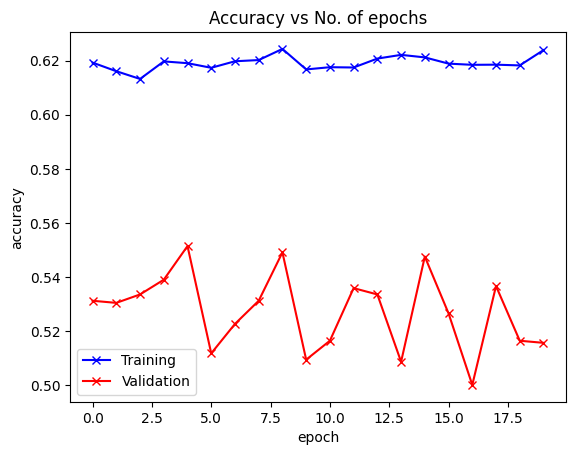

In [24]:
import matplotlib.pyplot as plt
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    val_acc = [x['val_acc'] for x in history]
    train_acc = [x['train_acc'] for x in history]
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs No. of epochs');
    

plot_accuracies(history)

## Test

In [25]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('./output/resnet_model20.pth'))
model.eval()

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 26)

In [27]:
# copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:26]
new_model.fc.bias.data = model.fc.bias.data[0:26]

load testdata

In [28]:
data_transforms = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(), # resnet needs input as tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # normalize images
    ])

In [29]:
data_dir = '../../02_data_crop_abc/test'

batch_size = 128
test_dataset = datasets.ImageFolder(data_dir, data_transforms)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

get test accuracy

In [30]:
def get_acc_loss_for_testdata(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients are calculated
        for images, labels in test_loader:
            outputs = model(images) # put image into model

            _, predicted = torch.max(outputs.data, 1)  # get predicted label
            total += labels.size(0)
            correct += torch.tensor(torch.sum(predicted == labels).item())

    test_acc =  correct / total

    print('Accuracy on test data: {} %'.format(100 * test_acc))

get_acc_loss_for_testdata(new_model, test_dl)

Accuracy on test data: 11.978021621704102 %


classification report

In [15]:
print("[INFO] evaluating network...")

def get_classification_report(model, test_loader):
	preds = []
	targets = []

	for image, label in test_loader:
			pred = model(image)
			preds.extend(pred.argmax(axis=1).cpu().numpy())
			targets.extend(label.cpu().numpy())

	# generate a classification report
	print(classification_report(targets, np.array(preds), target_names=test_dataset.classes))

get_classification_report(new_model, test_dl)

[INFO] evaluating network...
              precision    recall  f1-score   support

           a       0.15      0.09      0.12       140
           b       0.33      0.30      0.32       140
           c       0.10      0.10      0.10       140
           d       0.16      0.11      0.14       140
           e       0.07      0.06      0.06       140
           f       0.18      0.26      0.21       140
           g       0.03      0.04      0.04       140
           h       0.24      0.17      0.20       140
           i       0.16      0.25      0.20       140
           j       0.09      0.11      0.10       140
           k       0.07      0.13      0.09       140
           l       0.15      0.12      0.13       140
           m       0.11      0.10      0.11       140
           n       0.03      0.04      0.03       140
           o       0.18      0.21      0.20       140
           p       0.07      0.06      0.07       140
           q       0.12      0.10      0.11       14

confusion matrix

In [16]:
# get all predicted labels for test_data
def get_all_predictions(model, test_loader):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        images, labels = batch
        preds = model(images)
        _, pred_labels = torch.max(preds, dim=1)

        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [17]:
label_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n', 14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 
                   19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25: 'z'}

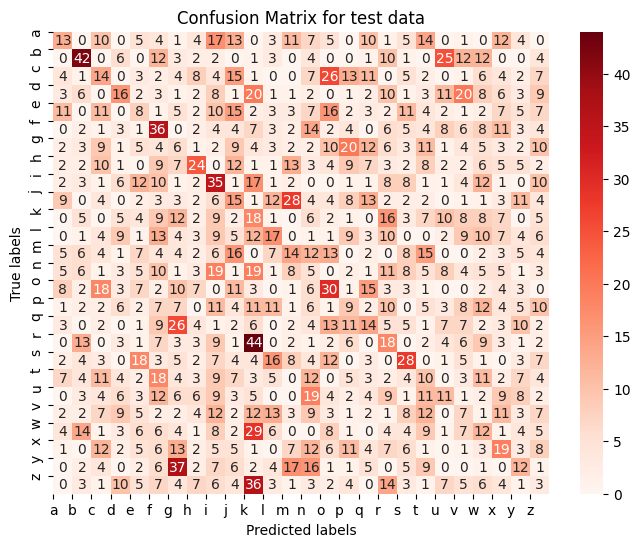

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
def plot_confusion_matrix(model, data_loader):
    all_preds, all_labels = get_all_predictions(model, data_loader)

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.xticks(ticks=range(len(label_to_letter)), labels=label_to_letter.values())
    plt.yticks(ticks=range(len(label_to_letter)), labels=label_to_letter.values())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for test data')
    plt.show()

plot_confusion_matrix(new_model, test_dl)

predict single image

In [19]:
# load image
image_path = '../test_images/00001.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image) # load image as tensor
input_batch = input_tensor.unsqueeze(0) # add additional dimension

In [20]:
# predict class
with torch.no_grad():
    output = model(input_batch)
_, predicted_class = output.max(1)

class_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
predictedd_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predictedd_class_name}')

The predicted class is: b


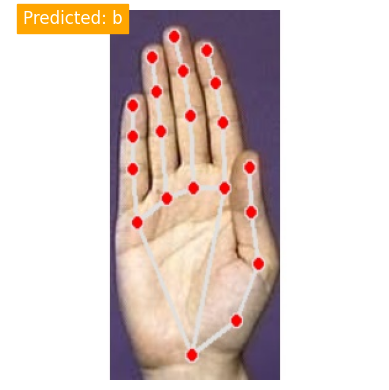

In [21]:
# visualize image
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10,10, f'Predicted: {predictedd_class_name}', fontsize=12, color='white', backgroundcolor='orange')
plt.show()